In [1]:
import os
import gps
import harp
import wave
import binaural
import datetime
import pandas as pd
import geopandas as gpd
import biosensing as bios
import matplotlib.pyplot as plt
from s3fs.core import S3FileSystem

# Dataset Structure

This proof-of-concept eMOTIONAL Cities dataset was collected using the `pluma` prototype data acquisition platform. More details.

In [2]:
# data folder
start_time = '8:45'
end_time = '10:00'
origin = datetime.datetime(2021, 9, 12, 8, 37, 22)
bucket = 's3://emotional-cities/data/nrg/poc-v0/2021-09-12T08-37-00/'
s3fs = S3FileSystem()

# Audio Data

Environmental audio was captured using binaural microphones on the participants' head. This data is used to measure directional ambient noise levels and also to synchronise various other media streams with the common Harp time reference.

In [3]:
audiofreq = 44100
samples_per_buffer = 441
audiotime = pd.read_csv(f'{bucket}BackPackLogData/Acquisition_Binaural_2021-09-12T08_37_22.csv',
                        header=None,usecols=[0])
audiotime.columns = ['Timestamp']
audiotime.Timestamp = origin + pd.to_timedelta(audiotime.Timestamp, 's')
audiotime['Samples'] = (audiotime.index + 1) * samples_per_buffer
audiotime['RecordingTime'] = pd.to_timedelta((audiotime.index + 1) * samples_per_buffer / audiofreq, 's')

<AxesSubplot:>

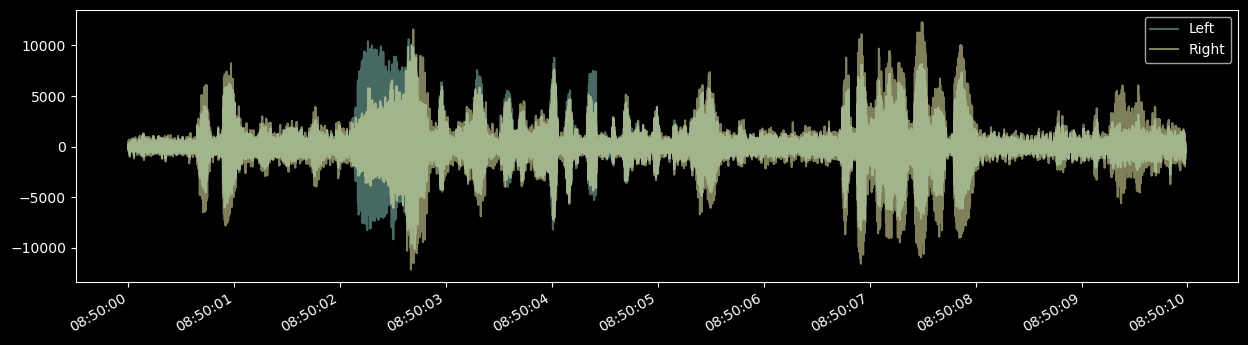

In [4]:
audio = wave.open(s3fs.open(f'{bucket}BackPackLogData/Acquisition_Binaural_2021-09-12T08_37_22.wav'))
binaural.between_time(audio, audiotime.Timestamp, '8:50', '8:50:10').plot(alpha=0.5,figsize=(15,4))

In [5]:
claps = pd.read_csv(os.path.join(bucket, 'Preprocessed/Acquisition_Binaural_2021-09-12T08_37_22_Claps.csv'),header=None)
claps.columns = ['Sample']
claps['RecordingTime'] = pd.to_timedelta(claps.Sample / audiofreq, 's')
claps['Buffer'] = claps.Sample // samples_per_buffer
claps['Timestamp'] = audiotime.Timestamp[claps.Buffer].reset_index(drop=True)
trials = claps.iloc[[11, 14, 17, 20, 34, 42, 46, 55]].reset_index(drop=True)

In [6]:
trial_labels = ['Portas do Sol','Escolas Gerais','Graça','Tram']
trial_colors = ['red', 'green', 'magenta', 'orange']
trials = pd.concat([trials.iloc[0::2].add_prefix('Start').reset_index(drop=True),
                   trials.iloc[1::2].add_prefix('End').reset_index(drop=True)],
                   axis=1)

In [7]:
trials

,StartSample,StartRecordingTime,StartBuffer,StartTimestamp,EndSample,EndRecordingTime,EndBuffer,EndTimestamp
0,18431366,0 days 00:06:57.944807256,41794,2021-09-12 08:50:13.800032,44458509,0 days 00:16:48.129455781,100812,2021-09-12 09:00:03.960032
1,80383322,0 days 00:30:22.751065760,182275,2021-09-12 09:13:38.580032,103683803,0 days 00:39:11.106643991,235110,2021-09-12 09:22:26.920032
2,123476935,0 days 00:46:39.930498866,279993,2021-09-12 09:29:55.750016,153649229,0 days 00:58:04.109501134,348410,2021-09-12 09:41:19.900032
3,166052822,0 days 01:02:45.370113379,376537,2021-09-12 09:46:01.180032,199996117,0 days 01:15:35.059342404,453505,2021-09-12 09:58:50.860032


# GPS Data

Location data was collected continuously throughout the entire walk using a GPS-RTK2 board.

In [7]:
# Initialize tilemapbase cache (run this only once)
if False:
    import tilemapbase as tmb
    tmb.init(create=True)

In [8]:
# GNGGA with bounding box and geopandas for euclidean distance (sampling rate is 1Hz so speed is m/s)
gngga = gps.read(os.path.join(bucket, 'BackPackLogData/Acquisition_GNGGA_2021-09-12T08_37_22.csv'), origin=origin)
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(gngga.Longitude, gngga.Latitude, gngga.Altitude), crs='epsg:4326')
gdf.to_crs(epsg=3310,inplace=True)
gdf.index = gngga.index
gngga['Speed'] = gdf.distance(gdf.shift(1))

c:\Users\gonca\Projects\github\emotional-cities\notebooks\.conda\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


<AxesSubplot:xlabel='Longitude'>

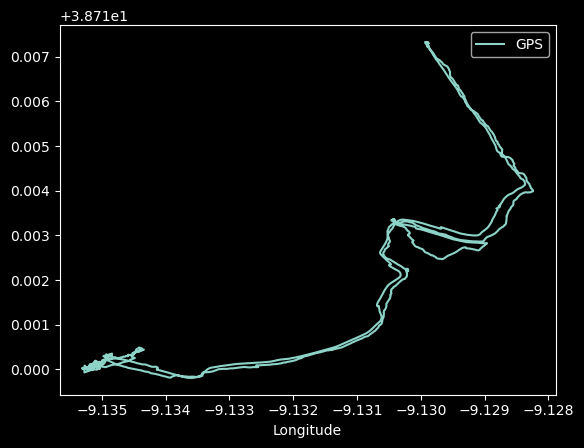

In [9]:
gps.plot(gngga, label='GPS')

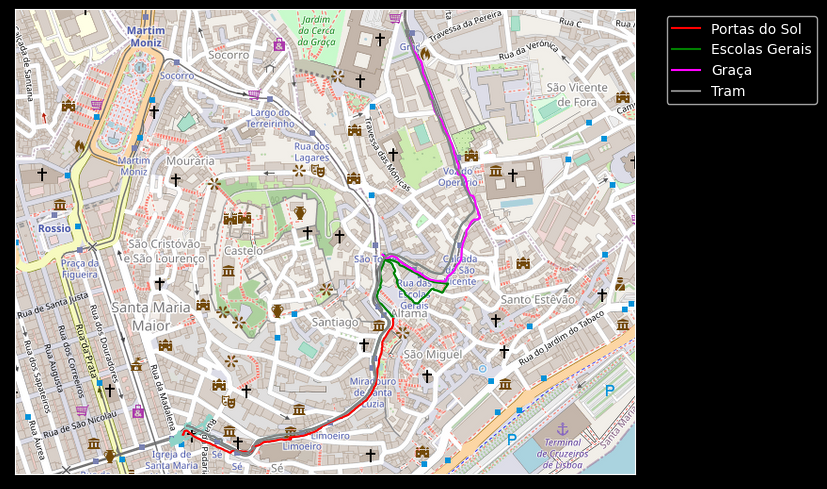

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
gps.plotmap(gngga, ax)
gps.plot(gngga, ax)
for i in range(len(trials)):    
    gps.plot(gngga[trials.StartTimestamp[i]:trials.EndTimestamp[i]], ax, color=trial_colors[i], label=trial_labels[i])
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# Heart Rate

We measured heart rate using two different sensors: ECG and Pulse Oximeter.

In [15]:
ecgfreq = 50
ecgdist=10
ecgheight=[250, 2000]

oximeter = harp.read(s3fs.open(f'{bucket}BackPackLogData/Acquisition_BioReg34_2021-09-12T08_37_22.bin'),
                    names=['Oxygen','HeartRate','Confidence','Status'], origin=origin)
ecg = harp.read(s3fs.open(f'{bucket}BackPackLogData/Acquisition_BioReg35_2021-09-12T08_37_22.bin'), names=['V'], origin=origin)
ecgfilt = pd.DataFrame(bios.highpass_filter(ecg.V, cutoff=10, fs=ecgfreq, order=5), index=ecg.index, columns=ecg.columns)

Text(0, 0.5, 'oxygen level (%)')

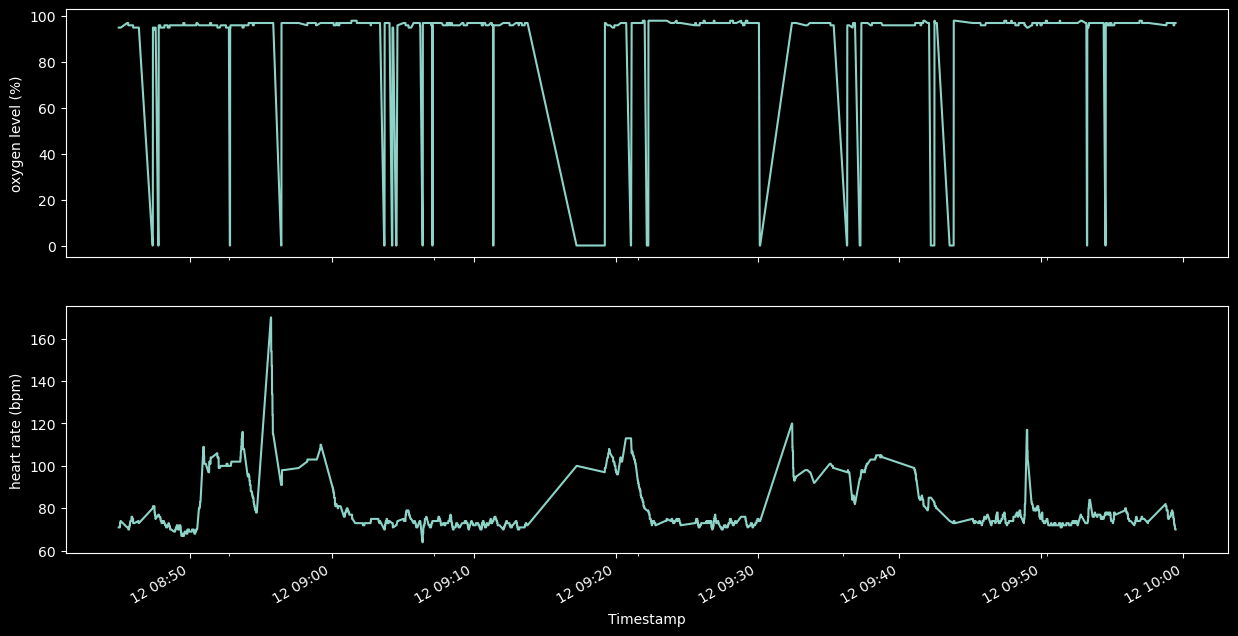

In [16]:
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(15,8), sharex=True)
oxiclip = oximeter.between_time(start_time, end_time)
oxiclip.HeartRate[oxiclip.Confidence > 50].plot(ax=ax1)
oxiclip.Oxygen[oxiclip.Confidence > 50].plot(ax=ax2)
ax1.set_ylabel('heart rate (bpm)')
ax2.set_ylabel('oxygen level (%)')

<AxesSubplot:xlabel='Timestamp'>

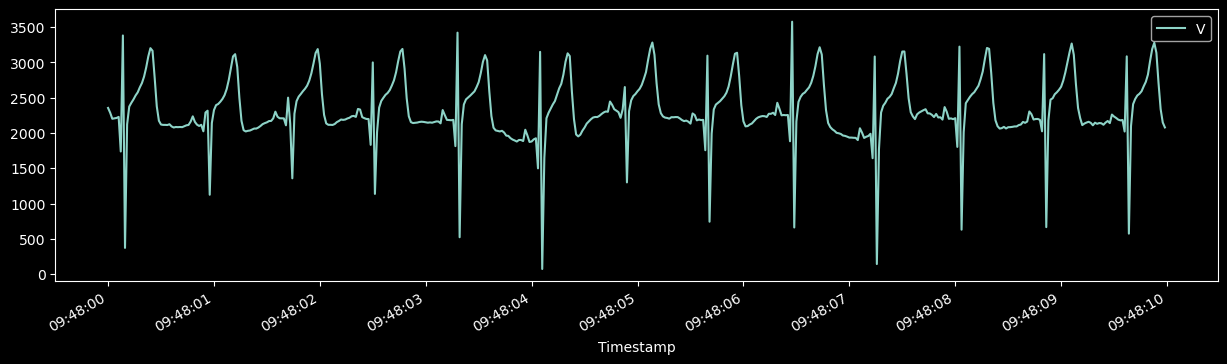

In [17]:
ecg.between_time('9:48','9:48:10').plot(figsize=(15,4))

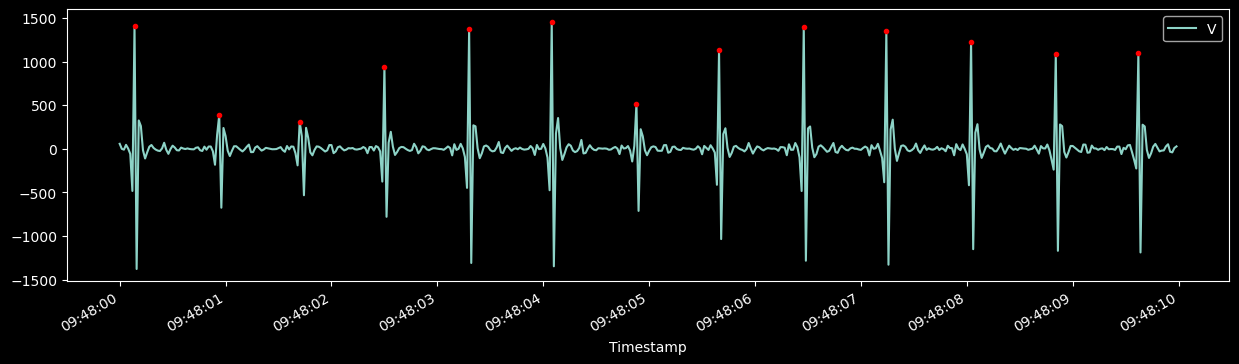

In [18]:
ecgdata = ecgfilt.between_time('9:48','9:48:10')
ecgdata.plot(figsize=(15,4))
beats, beatattributes = bios.ecgpeaks(ecgdata.V,height=ecgheight,distance=ecgdist)
plt.plot(beats, beatattributes['peak_heights'], 'r.')

# Electrodermal Activity

Galvanic skin response as a marker for stress was measured using an EDA sensor installed in the index finger.

In [19]:
eda = harp.read(s3fs.open(f'{bucket}BackPackLogData/Acquisition_BioReg36_2021-09-12T08_37_22.bin'), names=['V'], origin=origin)

# Climate Data

Micro-climate data was collected during the walk using the data acquisition system from Climateflux.

In [20]:
climate = pd.read_csv(os.path.join(bucket, 'Climateflux/Lisbon_20210912_pr.csv'))
climate_time = pd.to_datetime(climate[climate.columns[0]])
climate['Timestamp'] = climate_time
climate = climate.drop(columns=climate.columns[0]).set_index('Timestamp')

In [21]:
climate

,DRd_Altitude-Altitude_cm,DRd_Altitude-Geoidal Separation_cm,DRd_Motion-Course_deg,DRd_Motion-Speed_10m/h,DRd_Status-Satellites View_nan,JEC_Temperature_°C,L4M_Decibel_dB,Latitude,Le5_Get PM Concentration-PM100_µg/m³,Le5_Get PM Concentration-PM10_µg/m³,...,Le5_Get PM Count-Greater25um_nan,Le5_Get PM Count-Greater50um_nan,LhN_Humidity_%RH,LhN_Temperature_°C,Lhu_CO2 Concentration_ppm,Lhu_Humidity_%RH,Lhu_Temperature_°C,Longitude,MRT,UTCI
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-09-12 08:32:26,NaN,NaN,NaN,NaN,0.0,25.39,63.7,NaN,6.0,5.0,...,1.0,0.0,99.99,24.540,506.0,70.730,24.86,NaN,28.881686,27.1
2021-09-12 08:32:27,NaN,NaN,NaN,NaN,0.0,25.34,62.5,NaN,6.0,5.0,...,1.0,0.0,99.99,24.545,505.5,70.695,24.86,NaN,28.508987,27.0
2021-09-12 08:32:28,NaN,NaN,NaN,NaN,0.0,25.42,61.3,NaN,6.0,5.0,...,1.0,0.0,99.99,24.550,505.0,70.660,24.90,NaN,28.845908,27.1
2021-09-12 08:32:29,NaN,NaN,NaN,NaN,0.0,25.40,60.3,NaN,6.0,5.0,...,1.0,0.0,99.99,24.560,505.0,70.660,24.90,NaN,28.696933,27.0
2021-09-12 08:32:30,NaN,NaN,NaN,NaN,0.0,25.40,63.8,NaN,6.0,5.0,...,1.0,0.0,99.99,24.570,502.0,70.550,24.93,NaN,28.502146,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-12 10:12:40,3660.0,5070.0,161.35,192.0,5.0,26.10,60.5,38.709838,8.0,6.0,...,3.0,0.0,99.99,25.990,1022.0,63.810,27.14,9.135186,32.795182,29.6
2021-09-12 10:12:41,3670.0,5070.0,150.60,177.0,6.0,26.09,68.0,38.709833,8.0,6.0,...,3.0,0.0,99.99,26.000,1022.0,64.140,27.14,9.135181,32.848105,29.7
2021-09-12 10:12:42,3670.0,5070.0,149.21,185.0,5.0,26.09,75.3,38.709831,8.0,6.0,...,3.0,0.0,99.99,26.000,1022.0,64.140,27.14,9.135188,32.848105,29.7


# Pupil Data

Eye tracking data was collected onto an Android phone using the Pupil Invisible system. Synchronization needs to be done also using audio pulses.

In [22]:
pupiltrials = ['2021-09-12_08-43-04-6eda0cc4', '2021-09-12_09-07-19-8e04345b', '2021-09-12_09-23-44-075d4082', '2021-09-12_09-39-30-cf1a2884']
pupilstarts = [1952,467,215,798]
pupilends = [19664,16324,20748,23897]
pupilgaze = []
for i in range(len(pupiltrials)):
    gaze = pd.read_csv(os.path.join(bucket, 'PupilInvisible/{0}/exports/000/gaze_positions.csv'.format(pupiltrials[i])),usecols=range(5))
    gaze['Timestamp'] = pd.to_timedelta(gaze.gaze_timestamp - gaze.gaze_timestamp[i], 's') + trials.StartTimestamp[i]
    pupilgaze.append(gaze)
pupilgaze[0]

,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,Timestamp
0,67.067920,1952,1.0,0.411530,0.586601,2021-09-12 08:50:13.800032
1,67.072239,1952,1.0,0.424585,0.553054,2021-09-12 08:50:13.804351
2,67.075915,1952,1.0,0.477308,0.510885,2021-09-12 08:50:13.808027
3,67.083928,1952,1.0,0.460693,0.528488,2021-09-12 08:50:13.816040
4,67.087974,1953,1.0,0.449362,0.540359,2021-09-12 08:50:13.820086
...,...,...,...,...,...,...
117139,657.187935,19663,1.0,0.379770,0.513418,2021-09-12 09:00:03.920047
117140,657.191952,19663,1.0,0.374404,0.512713,2021-09-12 09:00:03.924064
117141,657.199949,19664,1.0,0.363704,0.511463,2021-09-12 09:00:03.932061
117142,657.203951,19664,1.0,0.361268,0.512593,2021-09-12 09:00:03.936063


# Correlations

In the below section, we show some possible combination plots of correlations between the different data streams in space and time.

## Heart rate dynamics

An example investigation of whether heart rate correlates with different variables recorded during the walk, taking into account geospatial location and time. Below we start by looking at the distribution of inter-beat intervals during the four different routes in the walk.

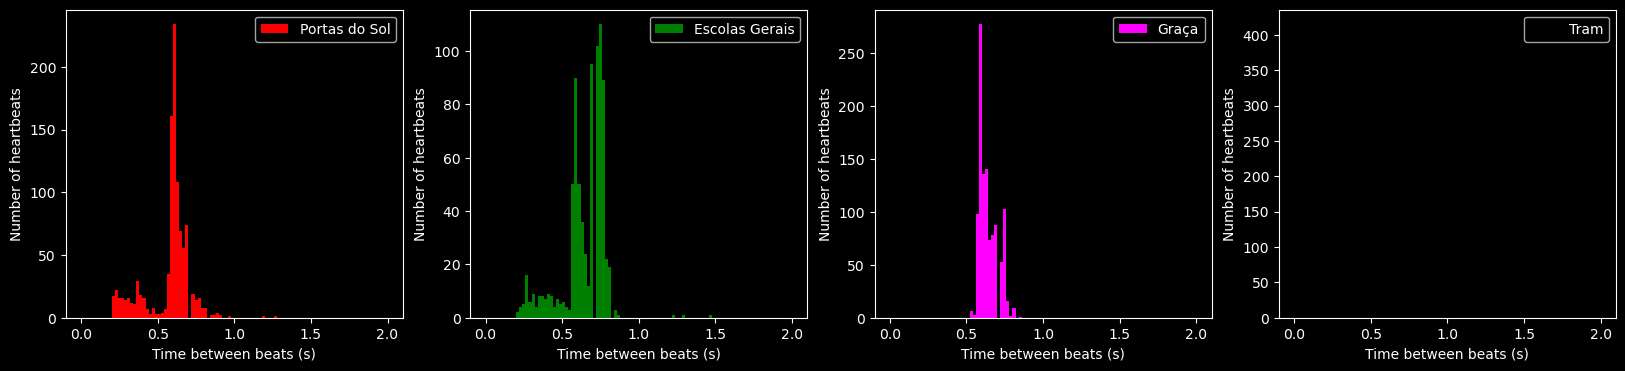

In [23]:
fig, axes = plt.subplots(1, len(trials), figsize=(20,4))
for i in range(len(trials)):
    ecgdata = ecgfilt[trials.StartTimestamp[i]:trials.EndTimestamp[i]].copy()
    beats, beatattributes = bios.ecgpeaks(ecgdata.V,height=ecgheight,distance=ecgdist)
    beats.to_series().diff()[1:].dt.total_seconds().plot(kind='hist',bins=100,range=[0,2],ax=axes[i],color=trial_colors[i],label=trial_labels[i])
    axes[i].set_xlabel('Time between beats (s)')
    axes[i].set_ylabel('Number of heartbeats')
    axes[i].legend()

Next we investigate temporal correlations of heart-rate with temperature, humidity, altitude, and speed.

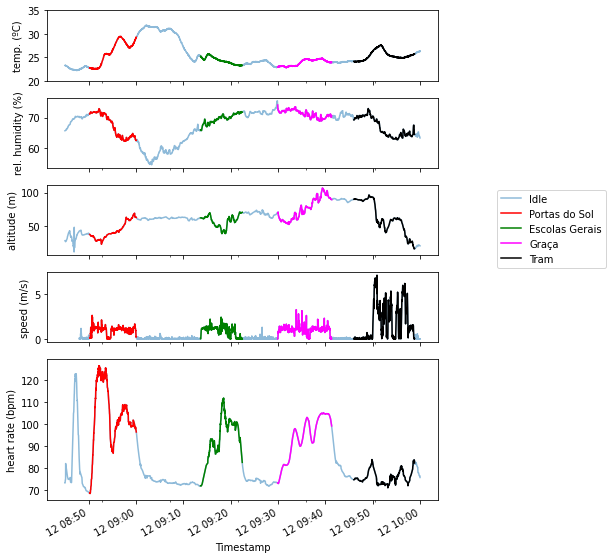

In [20]:
fig, (ax3, ax4, ax2, ax5, ax1) = plt.subplots(5, 1, figsize=(7, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 1, 2]})
ecgdata = ecgfilt.between_time(start_time,end_time)
ecgheartrate = bios.heartrate(ecgdata.V, height=ecgheight, distance=ecgdist)

ecgheartrate.plot(ax=ax1,alpha=0.5,label='Idle')
ax2.plot(gngga.between_time(start_time,end_time).Altitude,alpha=0.5,label='Idle')
ax3.plot(climate.between_time(start_time,end_time)['JEC_Temperature_°C'],alpha=0.5,label='Idle')
ax4.plot(climate.between_time(start_time,end_time)['Lhu_Humidity_%RH'],alpha=0.5,label='Idle')
ax5.plot(gngga.between_time('8:48',end_time).Speed,alpha=0.5,label='Idle')

for i in range(len(trials)):
    ecgheartrate[trials.StartTimestamp[i]:trials.EndTimestamp[i]].plot(ax=ax1,color=trial_colors[i],label=trial_labels[i])
    ax2.plot(gngga[trials.StartTimestamp[i]:trials.EndTimestamp[i]].Altitude,color=trial_colors[i],label=trial_labels[i])
    ax3.plot(climate[trials.StartTimestamp[i]:trials.EndTimestamp[i]]['JEC_Temperature_°C'],color=trial_colors[i],label=trial_labels[i])
    ax4.plot(climate[trials.StartTimestamp[i]:trials.EndTimestamp[i]]['Lhu_Humidity_%RH'],color=trial_colors[i],label=trial_labels[i])
    ax5.plot(gngga[trials.StartTimestamp[i]:trials.EndTimestamp[i]].Speed,color=trial_colors[i],label=trial_labels[i])
ax1.set_ylabel('heart rate (bpm)')
ax2.set_ylabel('altitude (m)')
ax3.set_ylabel('temp. (ºC)')
ax4.set_ylabel('rel. humidity (%)')
ax5.set_ylabel('speed (m/s)')
ax3.set_ylim(20, 35)
ax2.legend(bbox_to_anchor=(1.14,1), loc="upper left")